# Deep Learning -CNN

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, BatchNormalization, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.models import KeyedVectors
from gensim.downloader import load as gensim_load
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaiki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaiki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("D3.csv")

In [3]:
# Drop rows with missing values
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (28484, 2)


In [4]:
# Check the distribution of 'status' before resampling
print("\nStatus Value Counts before resampling:")
print(df['status'].value_counts())



Status Value Counts before resampling:
status
EDAnonymous      6947
adhd             5110
autism           4576
ptsd             4483
schizophrenia    4281
alcoholism       3087
Name: count, dtype: int64


In [5]:
# Define a function to resample the dataset for class balancing
def resample_data(data):
    # Find the maximum count among all statuses
    max_count = data['status'].value_counts().max()
    
    # Initialize an empty DataFrame to store resampled data
    resampled_data = pd.DataFrame()
    
    # Loop through each unique status and resample if needed
    for status in data['status'].unique():
        subset = data[data['status'] == status]
        if len(subset) < max_count:
            # Resample with replacement to match the maximum count
            subset_resampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
            resampled_data = pd.concat([resampled_data, subset_resampled])
        else:
            resampled_data = pd.concat([resampled_data, subset])
    
    return resampled_data

In [6]:
# Apply the resampling function to balance the classes
df = resample_data(df)

In [7]:
# Verify the resampled data
print("\nStatus Value Counts after resampling:")
print(df['status'].value_counts())
print("\nShape of resampled data:", df.shape)



Status Value Counts after resampling:
status
adhd             6947
alcoholism       6947
autism           6947
EDAnonymous      6947
ptsd             6947
schizophrenia    6947
Name: count, dtype: int64

Shape of resampled data: (41682, 2)


In [8]:
# Check for duplicate rows
duplicates_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates_count)


Number of duplicate rows: 17739


In [10]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['post'] = df['post'].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df['post'].head())



Sample preprocessed text:
860     found psych misdiagnosed adhd child psych clin...
3772    started strattera experience starting stratter...
3092    kvk tech dextroamphetamine quality concern hey...
466     mydayis nausea week one 70mg vyvanse everyday ...
4426    diagnosed add 28 history emotional abuse child...
Name: post, dtype: object


In [11]:
# Splitting Data and Encoding Labels
X = df['post'].values
y = df['status'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (33345,) (33345, 6)
Testing set shape: (8337,) (8337, 6)


In [12]:
# Tokenization and Padding
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Training Data Shape:", X_train_padded.shape)
print("Padded Testing Data Shape:", X_test_padded.shape)


Padded Training Data Shape: (33345, 100)
Padded Testing Data Shape: (8337, 100)


In [13]:
# Loading Pre-trained Word2Vec via Gensim Downloader
print("Downloading the pre-trained Google News Word2Vec model.")
word2vec_model = gensim_load("word2vec-google-news-300")
embedding_dim = word2vec_model.vector_size  # Typically 300
print("Download complete. Embedding dimension:", embedding_dim)

Download complete. Embedding dimension: 300


In [14]:
# Building the Embedding Matrix (with Fine-Tuning Enabled)
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_count = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found_count += 1
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Found embeddings for {found_count} out of {num_words} words.")


Found embeddings for 26232 out of 44876 words.


In [15]:
# Building the Enhanced CNN Model (Stacked Convolutions with Residual‐Inspired Flow)
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length,
                    weights=[embedding_matrix],
                    trainable=True))
# Regularize embeddings
model.add(SpatialDropout1D(0.3))

# First Convolutional Block
model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Convolutional Block (stacked)
model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())

# Global Pooling to collapse the time dimension
model.add(GlobalMaxPooling1D())

# Dense layers for final classification
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


C:\Users\kaiki\Documents\anaconda\envs\tensorflow_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      13,462,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,462,800 (51.36 MB)

 Trainable params: 13,462,800 (51.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callbacks for Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


In [17]:
# Training the Enhanced CNN Model
history = model.fit(X_train_padded, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stop, reduce_lr])


Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 206ms/step - accuracy: 0.4374 - loss: 1.6194 - val_accuracy: 0.8228 - val_loss: 0.6047 - learning_rate: 0.0010
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 54s 206ms/step - accuracy: 0.8593 - loss: 0.4258 - val_accuracy: 0.9130 - val_loss: 0.2754 - learning_rate: 0.0010
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.9170 - loss: 0.2612 - val_accuracy: 0.9351 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 54s 209ms/step - accuracy: 0.9496 - loss: 0.1638 - val_accuracy: 0.9521 - val_loss: 0.1590 - learning_rate: 0.0010
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 53s 204ms/step - accuracy: 0.9658 - loss: 0.1136 - val_accuracy: 0.9578 - val_loss: 0.1488 - learning_rate: 0.0010
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 197ms/step - accuracy: 0.9752 - loss: 0.0816 - val_accuracy: 0.9619 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 198ms/step - accuracy: 0.9

In [18]:
# Evaluating the Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))


261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9667 - loss: 0.1348

Test Accuracy: 96.57%


261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Confusion Matrix:
[[1341   26    7    4    6   17]
 [  10 1412    2   25    5   15]
 [  13    1 1336    4    4    3]
 [   7    9    1 1325    3   14]
 [  15   12    5    6 1306   18]
 [  13    7    4   10   20 1331]]


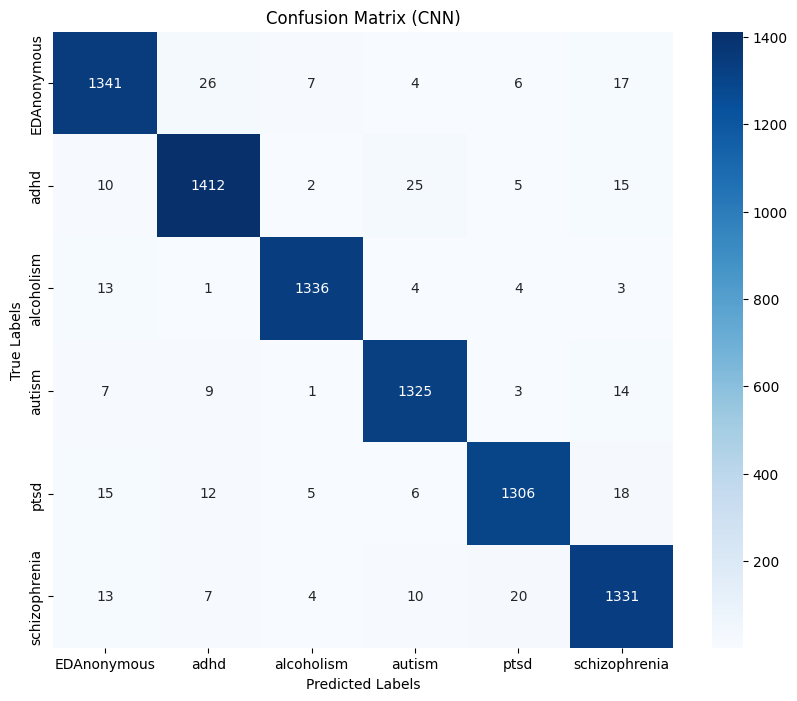

Classification Report:
               precision    recall  f1-score   support

  EDAnonymous     0.9585    0.9572    0.9579      1401
         adhd     0.9625    0.9612    0.9619      1469
   alcoholism     0.9860    0.9816    0.9838      1361
       autism     0.9643    0.9750    0.9696      1359
         ptsd     0.9717    0.9589    0.9653      1362
schizophrenia     0.9521    0.9610    0.9565      1385

     accuracy                         0.9657      8337
    macro avg     0.9659    0.9658    0.9658      8337
 weighted avg     0.9657    0.9657    0.9657      8337



In [23]:
# Generating Predictions and Evaluation Metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (CNN)')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))


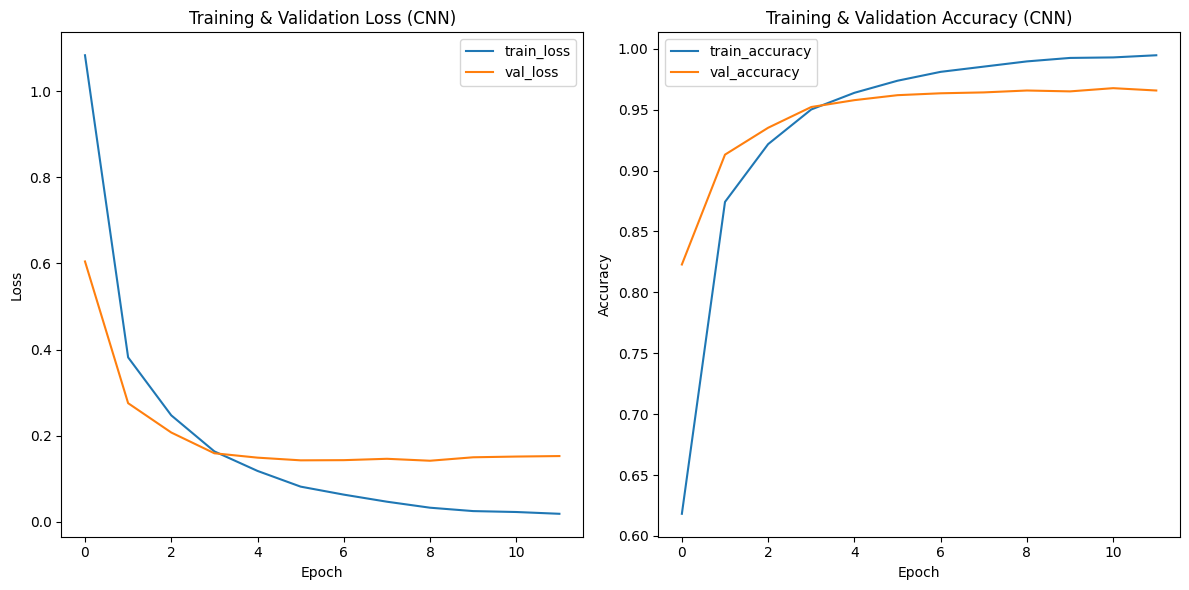

In [24]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

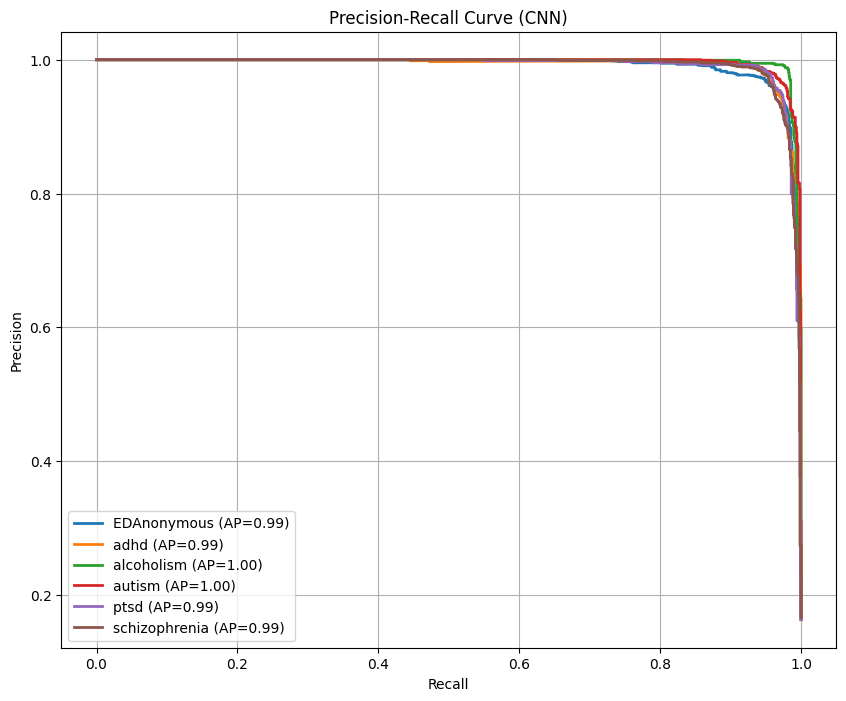

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class PR curve
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))
precision = dict()
recall = dict()
avg_precision = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{label_encoder.classes_[i]} (AP={avg_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CNN)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()



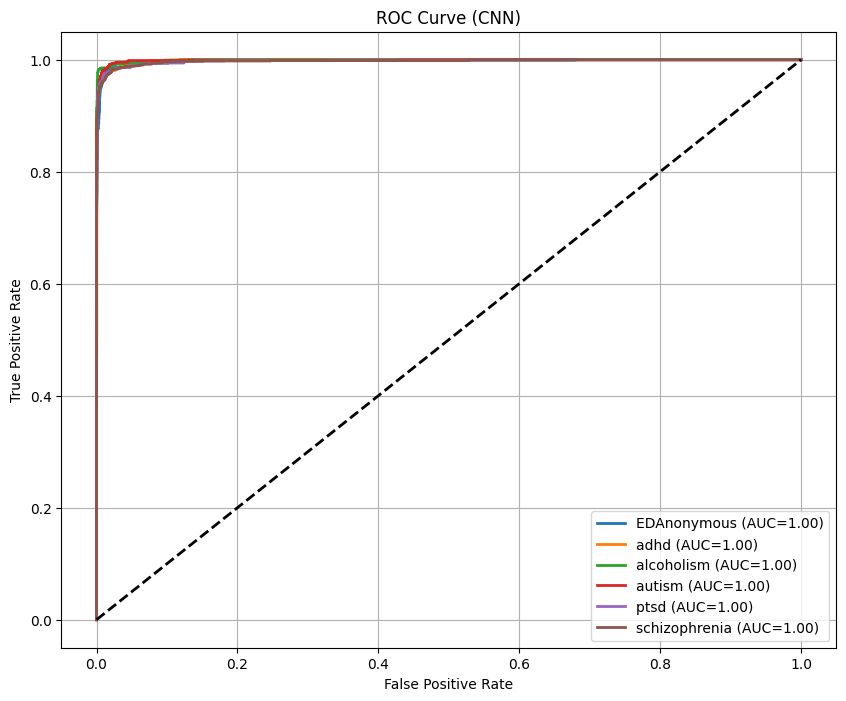

In [26]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.classes_[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (CNN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
